In [25]:
import numpy as np
import cv2
from moviepy.editor import VideoFileClip, VideoClip
import matplotlib.pyplot as plt
from project_utils import *

In [2]:
videofile = '../18Aug2018/k9_20180818T145529-0700.mp4' 
clip1 = VideoFileClip(videofile)
nf1 = int(clip1.fps*clip1.duration)
print(clip1.fps,clip1.duration,nf1)

29.97002997002997 10.65 319


In [30]:
img = clip1.get_frame(5)
ksize = 3
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
result = pipeline(img)
combined = np.zeros_like(dir_binary)
combined[(((result[:,:,1]==1) | (result[:,:,2]==1)) & (dir_binary == 1))] = 1
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 #minimum number of pixels making up a line
max_line_gap = 1    # maximum gap in pixels between connectable line segments
line_image = np.copy(combined)*0 # creating a blank to draw lines on

error: /home/travis/miniconda/conda-bld/conda_1486587071158/work/opencv-3.1.0/modules/imgproc/src/hough.cpp:424: error: (-215) image.type() == CV_8UC1 in function HoughLinesProbabilistic


In [106]:
import math

def grayscale(img):
    # Color filter based on HSV mapping followed by grayscale
        
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def draw_hlines(img,lines, color=[255,0,0], thickness=2):
    line_image = np.copy(img)*0
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > 0.25 and slope < 0.75 :
                cv2.line(line_image,(x1,y1),(x2,y2),color,thickness)
    return line_image    
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    line_image = np.copy(img)*0 # creating a blank to draw lines on
    li=0
    ri=0
    rightlines = []
    leftlines = []
    rslope=0
    lslope=0
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 == x2:
                continue
            slope=((y2-y1)*1.0/(x2-x1))
            if slope>=0.3 and slope<=1:
                ri += 1
                rightlines.append(line)
                rslope += slope
            elif slope>=-1 and slope <=-0.3:
                li += 1
                leftlines.append(line)
                lslope += slope
    
    rightlines = sorted(rightlines,key = lambda ar:ar[0,0])
    leftlines = sorted(leftlines,key = lambda ar:ar[0,0])
    while leftlines[-1][0,2] > rightlines[0][0,0]:
        leftlines.pop()
        rightlines.pop(0)
    
    x = []
    y = []        
    for line in rightlines:
        for x1,y1,x2,y2 in line:
            x += [x1, x2]
            y += [y1, y2]
            
    rline = np.polyfit(x,y,1)
    ylow = img.shape[0]
    rxlow = (ylow -rline[1])/rline[0]
    rxlow = int(rxlow)
    
    x = []
    y = []        
    for line in leftlines:
        for x1,y1,x2,y2 in line:
            x += [x1, x2]
            y += [y1, y2]
            
    lline = np.polyfit(x,y,1)
    lxlow = (ylow -lline[1])/lline[0]
    lxlow = int(lxlow)
    
    
    ymax = int(img.shape[0]*325/540.0)
    rxmax = int((ymax -rline[1])/rline[0])
    lxmax = int((ymax -lline[1])/lline[0])
    cv2.line(line_image,(lxlow,ylow),(lxmax,ymax),color,thickness)
    cv2.line(line_image,(rxlow,ylow),(rxmax,ymax),color,thickness)
    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0) 
    return lines_edges
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [109]:
gray = grayscale(img)
    
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray,kernel_size)
    
# Define our parameters for Canny and apply
low_threshold = 100
high_threshold = 200
edges = canny(blur_gray, low_threshold, high_threshold)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments
line_image = np.copy(img)*0 # creating a blank to draw lines on
    
# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
slopes = []
for line in lines:
    for x1,y1,x2,y2 in line:
        if x2 != x1:
            slopes.append((y2-y1)/(x2-x1))
shist, sedges = np.histogram(slopes, 20,(0.1,2))
lines_edges = draw_hlines(img, lines, [0,255,0], 10)


<IPython.core.display.Javascript object>


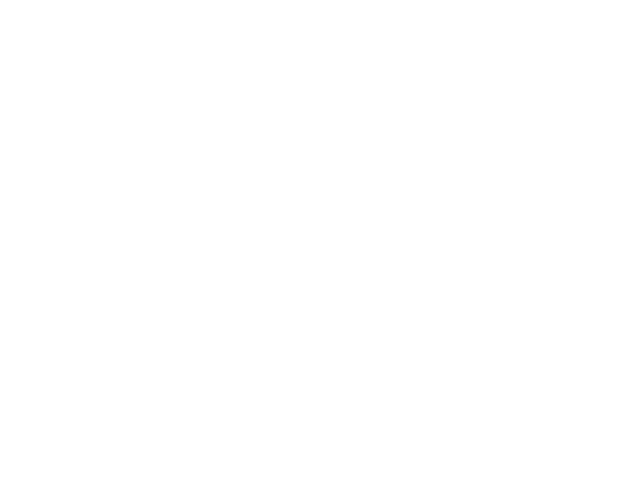

In [110]:
% matplotlib notebook
plt.imshow(lines_edges)

In [77]:
x1,y1,x2,y2 =(712,405,759,427)
(y2-y1)/(x2-x1)

0.46808510638297873

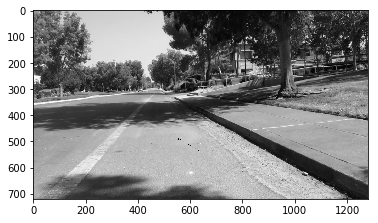

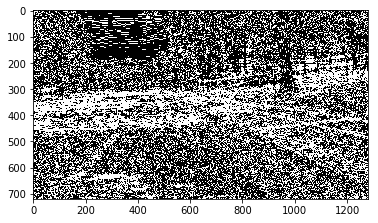

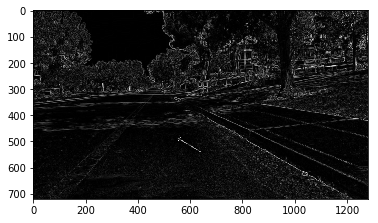

In [21]:
plt.imshow(gray,cmap='gray')
plt.figure()
plt.imshow(binary_output,cmap='gray')
plt.figure()
plt.imshow(gradmag,cmap='gray')


<IPython.core.display.Javascript object>


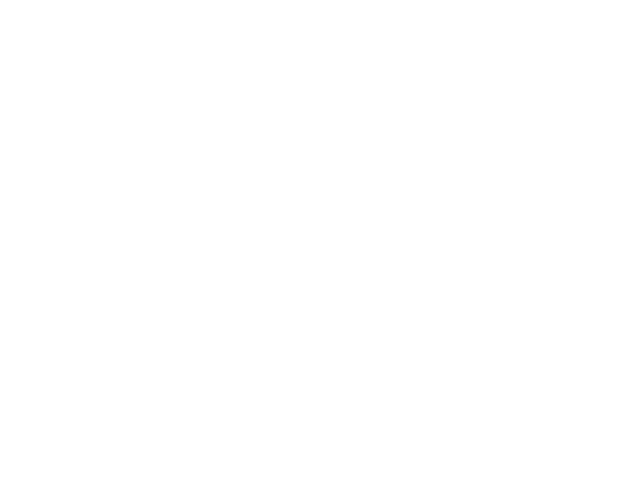

In [105]:
plt.figure()
plt.plot(sedges[1:],shist)